# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

plt.rcParams['font.serif'] = "Georgia"
plt.rcParams['font.family'] = "serif"

In [2]:
balls = pd.read_csv("../data/01_raw/all_matches.csv")

# Data Prep

## Filter non-T20s

In [3]:
# Excluding matches which we know are not T20s
balls['t20'] = balls['over_limit'].apply(lambda x: True if x in [0, 20] else False)
balls['date'] = pd.to_datetime(balls['date'], utc = True)

t20_matches = balls.groupby('event_id', as_index=False)[['t20']].min()
t20_matches = t20_matches[t20_matches['t20'] == True]

t20_matches_list = list(t20_matches['event_id'])
# This match was listed as 0 over limit but I happened to notice it was a 50 over game
t20_matches_list.remove(1204677)
t20_balls = balls[balls['event_id'].isin(t20_matches_list)]

## Exclude Certain Matches

In [4]:
matches = t20_balls.groupby(
    'event_id'
).head(1)[['event_id', 'date', 'batsman_striker_team_name', 'bowler_team_name']]

In [5]:
# Excluding matches with missing info
matches = matches[matches['batsman_striker_team_name'].notnull()]
# Excluding U19 matches - development formats not the most relevant
matches = matches[~matches['batsman_striker_team_name'].str.contains('Under-19s')]

# Excluding BBL matches with Power Surge + Bash Boost
bbl_teams = ['Sydney Thunder', 'Sydney Sixers', 'Melbourne Renegades', 'Melbourne Stars',
             'Hobart Hurricanes', 'Brisbane Heat', 'Perth Scorchers', 'Adelaide Strikers']

matches = matches[~((matches['batsman_striker_team_name'].isin(bbl_teams)) &
          (matches['date'] > pd.to_datetime('2020-6-01', utc=True)))]

# Excluding matches before the start of the IPL when T20 cricket changed significantly
matches = matches[matches['date'] >= pd.to_datetime('2008-4-18', utc=True)]

match_id_list = list(matches['event_id'])

In [6]:
t20_balls = t20_balls[t20_balls['event_id'].isin(match_id_list)]

In [7]:
# Excluding matches which were messed up with multiple matches listed with the same event id
t20_balls = t20_balls.merge(
    t20_balls.groupby(
        ['event_id', 'innings'], as_index = False
    )[['batsman_striker_team_id']].nunique().sort_values(
    'batsman_striker_team_id'
    ).rename(
        columns={'batsman_striker_team_id':'batting_teams'}
    )
)

t20_balls = t20_balls[t20_balls['batting_teams'] == 1]

In [8]:
# Excluding balls with too many overs, wickets or runs, or missing 2nd inns targets 
t20_balls = t20_balls[t20_balls['overs'] <= 20]
t20_balls = t20_balls[t20_balls['innings_wickets'] != 10]
t20_balls = t20_balls[(t20_balls['innings_runs'] < t20_balls['innings_target']) | (t20_balls['innings'] == 1)]
t20_balls = t20_balls[~((t20_balls['innings'] == 2) & (t20_balls['innings_target'] == 0))]

In [9]:
# Adding phases and over/wicket info
t20_balls['powerplay'] = t20_balls['overs'].apply(lambda x: 1 if x < 6 else 0)
t20_balls['middle'] = t20_balls['overs'].apply(lambda x: 1 if x >= 6 and x < 14 else 0)
t20_balls['death'] = t20_balls['overs'].apply(lambda x: 1 if x >= 14 else 0)
t20_balls['over_number'] = t20_balls['overs'].apply(lambda x: math.floor(x))
t20_balls['wicket'] = t20_balls['outcome'].apply(lambda x: 1 if x == 'out' else 0)

In [10]:
# Shifting to be # of wickets before the ball rather than after
t20_balls['innings_wickets'] = t20_balls.sort_values(
    ['event_id', 'innings', 'overs', 'ball_no']
).groupby(['event_id', 'innings'])['innings_wickets'].shift(1).fillna(0)

In [11]:
def add_extra_ball(df):
    
    if df['innings_remaining_balls'] == 0 and df['innings'] == 2:
        df['innings_remaining_balls'] = 1
        df['run_rate_required'] = df['innings_remaining_runs']

    return df

In [12]:
# Avoiding 0s or NAs in the run_rate_required column. Seems to go wrong where extra balls were mistakenly bowled
t20_balls = t20_balls.apply(add_extra_ball, axis=1)

In [13]:
# Adding year columns
t20_balls['year'] = pd.DatetimeIndex(t20_balls['date']).year

## Wides

I've decided to include extras as part of the batters' score - although there will obviously be occasions where batters deserve no credit for extras, there are lots of occasions where they do deserve credit, such as a quick single off a leg-bye. There are also batters who face significantly more wides than others - over a small sample this may be random variation, but taking a large sample (min. 5000 balls in our dataset), it is clear that for example Chris Gayle faces more wides than Rohit Sharma. This may be because Gayle is so deadly when anything is bowled in his arc that bowlers resort to trying to hide it from him, and as a result bowl more wides. For this reason, extras will be counted towards the batter in this rating system.

In [14]:
# Calculate average # of wides per ball
wides_faced = t20_balls.groupby(
    'batsman_striker_name'
).agg(
    {'batter_balls_faced':'count', 'innings_wides':'mean'}
)

In [15]:
wides_faced[wides_faced['batter_balls_faced'] >= 5000].sort_values('innings_wides', ascending=False)

,batter_balls_faced,innings_wides
batsman_striker_name,,
Chris Gayle,8465,0.063910
Kieron Pollard,5867,0.057610
Brendon McCullum,5248,0.048780
Lendl Simmons,5487,0.044833
Suresh Raina,5449,0.043311
David Warner,6354,0.040762
Aaron Finch,6539,0.038844
Shikhar Dhawan,5965,0.035708
Virat Kohli,7008,0.032249


# Model Training

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_validate

In [17]:
# Splitting data for model training + testing
train_balls = t20_balls[t20_balls['year'] < 2020]
test_balls = t20_balls[t20_balls['year'] >= 2020]

In [55]:
len(test_balls)

223276

In [18]:
first_inns = train_balls[train_balls['innings'] == 1]
second_inns = train_balls[train_balls['innings'] == 2]

## Expected Runs

In [19]:
# Splitting features + target
X1 = first_inns[['innings_wickets', 'batter_balls_faced', 'powerplay', 'over_number']]
y1 = first_inns['score_value']

X2 = second_inns[['innings_wickets', 'batter_balls_faced', 'powerplay', 'over_number', 'run_rate_required']]
y2 = second_inns['score_value']

In [20]:
lin_reg = LinearRegression()
rf = RandomForestRegressor()
ada = AdaBoostRegressor()
grad = GradientBoostingRegressor()
xg = XGBRegressor()

In [21]:
# Cross Validation
models = [lin_reg, rf, ada, grad, xg]
for model in models:
    results = cross_validate(model, X1, y1, cv = 10, scoring='neg_mean_absolute_error')
    score = round(results['test_score'].mean(), 3)
    time = round(results['fit_time'].mean(), 3)
    print(f"{model}: {score} in {time}")

LinearRegression(): -1.108 in 0.025
RandomForestRegressor(): -1.118 in 13.959
AdaBoostRegressor(): -1.591 in 3.997
GradientBoostingRegressor(): -1.108 in 8.139
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...): -1.11 in 4.553


In [22]:
models = [lin_reg, rf, ada, grad, xg]
for model in models:
    results = cross_validate(model, X2, y2, cv = 10, scoring='neg_mean_absolute_error')
    score = round(results['test_score'].mean(), 3)
    time = round(results['fit_time'].mean(), 3)
    print(f"{model}: {score} in {time}")

LinearRegression(): -1.1 in 0.03
RandomForestRegressor(): -1.25 in 50.336
AdaBoostRegressor(): -1.49 in 5.006
GradientBoostingRegressor(): -1.103 in 12.859
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=None, reg_lambda=None, ...): -1.106 in 4.594


The Linear Regression seems to be the best performing model in terms of mean absolute error, marginally better than the Gradient Boost and its training time is signifcantly quicker. If I had more time to work on this, optimising the hyper-parameters, particularly of the ensemble models, could be a good way to improve the performance of the model.

In [21]:
model1 = LinearRegression()
model2 = LinearRegression()

In [22]:
model1.fit(X1, y1)
model2.fit(X2, y2)

LinearRegression()

## Value of Wickets

While the expected runs model can show us how much players are scoring above/below an expected rate, it wouldn't account for the value of wickets. In order to include this in the player ratings, this wicket-value model can predict how many runs are expected in the remainder of the innings given # of wickets and balls remaining. From this we can see how many runs a wicket is worth at any point in the innings. Since the number of runs scored in the remainder of the innings would be affected by the target in a run chase, this model is trained on first innings only.

In [23]:
def calculate_remaining_balls(df):
    
    if df['innings'] == 1:
        if df['innings_remaining_balls'] == 0:
            df['innings_remaining_balls'] = 121 - df['match_ball_no']
            
    return df

In [24]:
# Adding remaining balls for 1st innings, since it is mostly missing
first_inns = first_inns.apply(calculate_remaining_balls, axis=1)

In [25]:
# Calculating runs scored in the remainder of an innings
first_inns = first_inns.merge(
    first_inns.groupby(
        ['event_id', 'innings'], as_index = False
    )['innings_runs'].max().rename(
        columns={'innings_runs':'innings_total'}
    ),
    on=['event_id', 'innings'],
    how='left'
)

first_inns['runs_after'] = first_inns['innings_total'] - first_inns['innings_runs'] + first_inns['score_value']

In [26]:
# Excluding innings that aren't complete in the data
last_balls = first_inns.sort_values('match_ball_no').groupby(['event_id', 'innings']).tail(1)

complete_innings = list(
    last_balls[
        (last_balls['innings_remaining_balls'] == 1) |
        ((last_balls['innings_wickets'] == 9) & (last_balls['outcome'] == 'out'))
    ]['event_id'])

first_inns_train = first_inns[first_inns['event_id'].isin(complete_innings)]

I've only included these 2 features currently, but with more time this could become more complex. For example, there may be certain situations (e.g. batting with a set batter vs with tailenders, high v low scoring matches) where wickets are valued more than others. There's a risk that this could bias the model against certain players (e.g. tailenders wickets count as more valuable because they tend to be batting with other tailenders), so I would need to investigate this to ensure it is fair.

This relationship seems to be exponential, since wickets are exponentially more valuable at the start of the innings than at the end.

In [27]:
X1 = first_inns_train[['innings_wickets', 'innings_remaining_balls']]
# Adding 1 to avoid np.log(0) == -Inf. 
y1 = np.log(first_inns_train['runs_after'] + 1)

In [28]:
wicket_model = LinearRegression()
wicket_model.fit(X1, y1)

LinearRegression()

In [29]:
# Creating a dataframe to predict for every ball/wicket combo
wickets = pd.DataFrame(
    np.arange(0,11,1)
).rename(
    columns={0:'innings_wickets'}
)

wickets['join'] = 0

balls_remaining = pd.DataFrame(
    np.arange(0,121,1)
).rename(
    columns={0:'innings_remaining_balls'}
)

balls_remaining['join'] = 0

merged = wickets.merge(balls_remaining).drop(columns=['join'])

In [30]:
# Adding 1 to reverse the +1 adjustment earlier
merged['pred'] = np.exp(wicket_model.predict(merged)) - 1

# The value of a wicket is calculated as the difference between the predictions with n and n-1 wickets left
merged['next_wicket'] = merged.groupby('innings_remaining_balls')['innings_wickets'].shift(-1)
merged['wicket_pred'] = merged.groupby('innings_remaining_balls')['pred'].shift(-1)

merged['value_of_wicket'] = merged['wicket_pred'] - merged['pred']

# Taking the average of all wicket numbers. Otherwise opening batters are unfairly punished
value_of_wicket = merged.groupby('innings_remaining_balls', as_index = False)[['value_of_wicket']].mean()

## Value of Survival

There is also value in wicket preservation, since it enables teammates to take more risks in the balls they face without increasing the risk of not batting out the overs. About 5% of balls in the dataset result in wickets, which means that before every ball, the probable cost to your team of getting out is 5% of the value of the wicket for that ball. If losing a wicket costs 10 runs then the probable cost would be 0.5 runs. By surviving that ball, you've enabled your team to avoid that probable cost of 0.5 runs, which is the value of suriving. 

In [31]:
# Calculate % of balls that are wickets
wicket_perc = train_balls['wicket'].mean()

In [32]:
# Calculate value of survival for every ball
value_of_wicket['value_of_survival'] = value_of_wicket['value_of_wicket'] * wicket_perc * -1

## Runs Gained Calculations

In [33]:
# Predicting runs for 1st innings 
test1 = test_balls[test_balls['innings'] == 1]
Xtest1 = test1[['innings_wickets', 'batter_balls_faced', 'powerplay', 'over_number']]
ytest1 = test1['score_value']
Xtest1['pred'] = model1.predict(Xtest1)
Xtest1['actual'] = ytest1

results1 = Xtest1.merge(
    test1[['event_id','batsman_striker_name', 'bowler_name', 'innings', 'outcome',
           'date', 'middle', 'death', 'wicket', 'innings_remaining_balls']],
    left_index = True, right_index = True
)

<ipython-input-33-4e682fa1706e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest1['pred'] = model1.predict(Xtest1)
<ipython-input-33-4e682fa1706e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest1['actual'] = ytest1


In [34]:
# Predicting runs for 2nd innings 
test2 = test_balls[test_balls['innings'] == 2]
Xtest2 = test2[['innings_wickets', 'batter_balls_faced','powerplay', 'over_number', 'run_rate_required']]
ytest2 = test2['score_value']
Xtest2['pred'] = model2.predict(Xtest2)
Xtest2['actual'] = ytest2

results2 = Xtest2.merge(
    test2[['event_id', 'batsman_striker_name', 'bowler_name', 'innings', 'outcome',
           'date', 'middle', 'death', 'wicket', 'innings_remaining_balls']],
                        left_index = True, right_index = True)

<ipython-input-34-f8c101a8feb5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest2['pred'] = model2.predict(Xtest2)
<ipython-input-34-f8c101a8feb5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xtest2['actual'] = ytest2


In [35]:
results1['run_rate_required'] = None
results = pd.concat([results1, results2])
# Since a wide doesn't count as a ball, expected runs = 0. No ball counts because batter can still hit it
results['wide_multiplier'] = results['outcome'].apply(lambda x: 0 if x == 'wide' else 1)
results['pred'] = results['pred'] * results['wide_multiplier']

In [36]:
# Add value of wickets/survival
results = results.merge(value_of_wicket)
results['runs_gained_wicket'] = results['wicket'] * results['value_of_wicket']
results['runs_gained_survival'] = (1 - results['wicket']) * results['value_of_survival']

In [37]:
# Calculate runs gained value
results['runs_gained'] = (results['actual'] - results['pred']) +\
                                results['runs_gained_wicket'] + results['runs_gained_survival']

In [38]:
# Calculate match runs gained for batters
bat_performance = results.groupby(
    ['event_id', 'date', 'batsman_striker_name'], as_index=False
).agg(
    {'batter_balls_faced':'count', 'runs_gained':'sum'}
)

In [39]:
# Calculate match runs gained for bowlers
bowl_performance = results.groupby(
    ['event_id', 'date', 'bowler_name'], as_index=False
).agg(
    {'batter_balls_faced':'count', 'runs_gained':'sum'}
)

# Changing this to positive since fewer runs is better for bowlers
bowl_performance['runs_gained'] = bowl_performance['runs_gained'] * -1

## Span Testing

In [40]:
# Excluding batters/bowlers with fewer than 20 innings
bat_innings = bat_performance.groupby('batsman_striker_name', as_index=False)[['runs_gained']].count()
included_batters = list(bat_innings[bat_innings['runs_gained'] >= 20]['batsman_striker_name'])

bowl_innings = bowl_performance.groupby('bowler_name', as_index=False)[['runs_gained']].count()
included_bowlers = list(bowl_innings[bowl_innings['runs_gained'] >= 20]['bowler_name'])

In [41]:
# Excluding batters/bowlers with fewer than 20 innings
bat_test = bat_performance[
    bat_performance['batsman_striker_name'].isin(included_batters)
].sort_values(
    'date'
).set_index(
    'date'
)

bowl_test = bowl_performance[
    bowl_performance['bowler_name'].isin(included_bowlers)
].sort_values(
    'date'
).set_index(
    'date'
)

In [42]:
def test_span(span, bat=True):

    if bat:
        bat_rating = bat_test.groupby(
            'batsman_striker_name'
        )[['runs_gained']].ewm(
            span=span
        ).mean().rename(
            columns={'runs_gained':'rating'}
        ).reset_index()

        bat_rating_added = bat_test.reset_index().merge(bat_rating)

        bat_rating_added['rating_before'] = bat_rating_added.groupby('batsman_striker_name')['rating'].shift(1)

        bat_rating_added['abs_error'] = abs(bat_rating_added['runs_gained'] - bat_rating_added['rating_before'])

        return bat_rating_added['abs_error'].mean()
    
    else:
        
        bowl_rating = bowl_test.groupby(
            'bowler_name'
        )[['runs_gained']].ewm(
            span=span
        ).mean().rename(
            columns={'runs_gained':'rating'}
        ).reset_index()

        bowl_rating_added = bowl_test.reset_index().merge(bowl_rating)

        bowl_rating_added['rating_before'] = bowl_rating_added.groupby('bowler_name')['rating'].shift(1)

        bowl_rating_added['abs_error'] = abs(bowl_rating_added['runs_gained'] - bowl_rating_added['rating_before'])

        return bowl_rating_added['abs_error'].mean()   

In [43]:
# Testing different span values to find the most predictive smoothing
span_values = [5,10,15,20,25,30,35,40,45,50]
bat_span_results = {}
bowl_span_results = {}

for span in span_values:
    bat_mae = test_span(span, bat=True)
    bat_span_results[span] = bat_mae
    
    bowl_mae = test_span(span, bat=False)
    bowl_span_results[span] = bowl_mae

In [44]:
bat_span = min(bat_span_results, key=bat_span_results.get)
bowl_span = min(bowl_span_results, key=bowl_span_results.get)

In [45]:
def plot_smooth_ratings(name, bat=True):
    
    fig = plt.figure(figsize=(16,9))
    
    if bat:
        df = bat_performance[bat_performance['batsman_striker_name'] == name].sort_values('date')
        df.set_index('date', inplace=True)
        ax = df['runs_gained'].plot(style = 'r--', label = name)
        ax = df['runs_gained'].ewm(span = bat_span).mean().plot(style = 'b', label = ' Exponential moving average')
        ax.set_title(f"{name}: Batting", size=20)
    else:
        df = bowl_performance[bowl_performance['bowler_name'] == name].sort_values('date')
        df.set_index('date', inplace=True)
        ax = df['runs_gained'].plot(style = 'r--', label = name)
        ax = df['runs_gained'].ewm(span = bowl_span).mean().plot(style = 'b', label = ' Exponential moving average')
        ax.set_title(f"{name}: Bowling", size=20)
        
    ax.set_xlabel("Date", size=15)
    ax.set_ylabel("Runs Gained", size=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False);

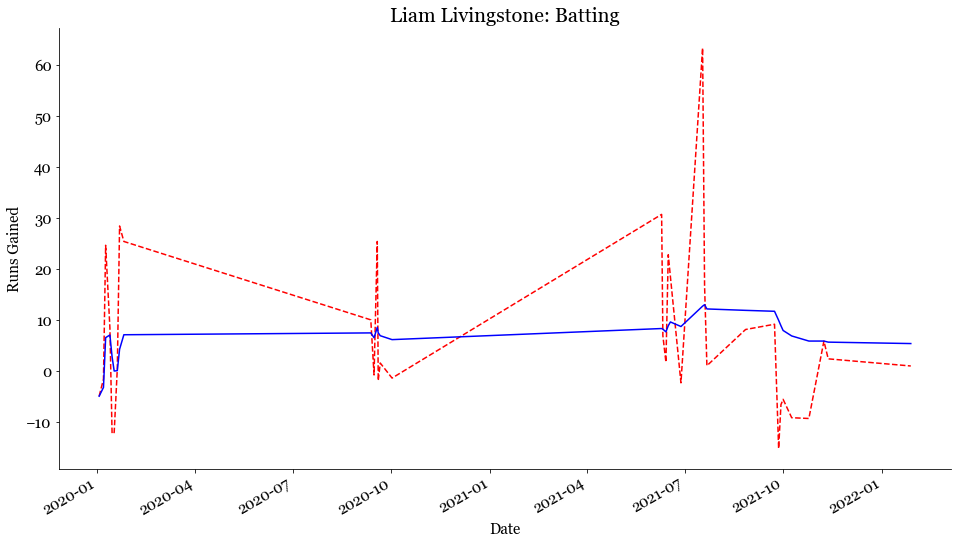

In [46]:
plot_smooth_ratings('Liam Livingstone', bat=True)

In [47]:
# Finding top 10 batters
batting_ratings = bat_performance[
    bat_performance['batsman_striker_name'].isin(included_batters)
].sort_values(
    'date'
).set_index(
    'date'
).groupby(
    'batsman_striker_name'
)[['runs_gained']].ewm(
    span=bat_span
).mean().groupby(
    'batsman_striker_name'
).tail(1).sort_values(
    'runs_gained', ascending=False
).rename(
    columns={'runs_gained':'player_rating'}
)

batting_ratings.head(10)

,,player_rating
batsman_striker_name,date,
Joe Clarke,2021-08-25 19:00:00+00:00,12.860134
Josh Inglis,2021-07-18 18:30:00+00:00,12.077551
Mohammad Rizwan,2021-12-17 18:00:00+00:00,11.801734
Daniel Bell-Drummond,2021-09-18 18:45:00+00:00,10.175033
Will Jacks,2021-07-16 14:30:00+00:00,9.772050
Ruturaj Gaikwad,2021-11-09 13:00:00+00:00,9.479490
Mayank Agarwal,2021-10-08 14:00:00+00:00,9.310949
Jos Buttler,2021-11-11 18:00:00+00:00,9.104109
KL Rahul,2021-11-20 19:00:00+00:00,8.553045


In [48]:
# Finding top 10 bowlers
bowling_ratings = bowl_performance[
    bowl_performance['bowler_name'].isin(included_bowlers)
].sort_values(
    'date'
).set_index(
    'date'
).groupby(
    'bowler_name'
)[['runs_gained']].ewm(
    span=bowl_span
).mean().groupby(
    'bowler_name'
).tail(1).sort_values(
    'runs_gained', ascending=False
).rename(
    columns={'runs_gained':'player_rating'}
)

bowling_ratings.head(10)

,,player_rating
bowler_name,date,
Wanindu Hasaranga de Silva,2021-11-05 18:00:00+00:00,9.999881
Dinesh Nakrani,2021-11-20 09:15:00+00:00,9.924715
Ravisrinivasan Sai Kishore,2021-11-22 12:00:00+00:00,7.714359
Mujeeb Ur Rahman,2021-11-08 14:00:00+00:00,6.762122
Jasprit Bumrah,2021-11-09 18:00:00+00:00,6.158964
Nasum Ahmed,2021-11-23 14:00:00+00:00,4.778513
Avesh Khan,2021-10-14 18:00:00+00:00,4.679448
Anrich Nortje,2021-11-07 18:00:00+00:00,4.529335
Rashid Khan,2021-11-08 14:00:00+00:00,4.487015


# Analysis

## Phase Performance

This Runs Gained model can be used to assess players' (and teams') performance in different phases of an innings. Building a squad that can perform in all phases is clearly important, but so is deploying your players in the phases of the game that suit them the best.

Looking at the batting table below, we can see that AB de Villiers has scored at an average rate in the Powerplay and just below average in the Middle, but has been one of the very best at the Death. This would suggest that he's best held back until later on in the innings, as RCB started to do at the end of his career. 

For the bowlers, you can see that Jofra Archer has been below average at the Death, but well above average in the Powerplay and particularly in the Middle. Teams should maximise his abilities before the end of the innings, and find other bowlers who can bowl at the Death. Jasprit Bumrah is a rare example of a player whose performance remains fairly constant in all 3 phases. This makes him incredibly versatile, so he can be used flexibly throughout an innings depending on what other bowlers a team has and to target certain batters.

In [49]:
# Batting Phases 
pp_bat = results[results['powerplay'] == 1].groupby(
    'batsman_striker_name', as_index = False
).agg(
    {'batter_balls_faced':'count', 'runs_gained':'mean'}
).rename(
    columns={'batter_balls_faced':'pp_balls', 'runs_gained':'pp_runs_gained'}
)

mid_bat = results[results['middle'] == 1].groupby(
    'batsman_striker_name', as_index = False
).agg(
    {'batter_balls_faced':'count', 'runs_gained':'mean'}
).rename(
    columns={'batter_balls_faced':'mid_balls', 'runs_gained':'mid_runs_gained'}
)


death_bat = results[results['death'] == 1].groupby(
    'batsman_striker_name', as_index = False
).agg(
    {'batter_balls_faced':'count', 'runs_gained':'mean'}
).rename(
    columns={'batter_balls_faced':'death_balls', 'runs_gained':'death_runs_gained'}
)

phase_bat_performance = pp_bat.merge(mid_bat, how='outer').merge(death_bat, how='outer')

phase_bat_performance[
    phase_bat_performance['death_balls'] >= 150
].sort_values(
    'death_runs_gained', ascending=False
).head(20)

,batsman_striker_name,pp_balls,pp_runs_gained,mid_balls,mid_runs_gained,death_balls,death_runs_gained
566,Kieron Pollard,10.0,3.090349,316.0,0.218451,509.0,0.581009
967,Shahrukh Khan,5.0,-0.653463,113.0,0.296853,225.0,0.560587
1,AB de Villiers,66.0,0.005049,259.0,-0.135382,285.0,0.557029
86,Andre Russell,9.0,-0.179441,226.0,0.072582,438.0,0.533072
851,Ravindra Jadeja,6.0,-0.882663,87.0,0.161026,278.0,0.484342
203,Cam Fletcher,11.0,-0.593686,128.0,0.336705,170.0,0.462403
1409,Josh Clarkson,NaN,NaN,133.0,0.375410,156.0,0.432146
986,Shimron Hetmyer,171.0,-0.347248,442.0,0.124110,310.0,0.420851
364,Glenn Phillips,281.0,-0.148825,616.0,0.359363,257.0,0.382038
398,Harry Brook,45.0,-0.449666,227.0,0.355258,200.0,0.372888


In [50]:
# Bowling Phases 
results['bowl_runs_gained'] = results['runs_gained'] * -1

pp_bowl = results[results['powerplay'] == 1].groupby(
    'bowler_name', as_index = False
).agg(
    {'batter_balls_faced':'count', 'bowl_runs_gained':'mean'}
).rename(
    columns={'batter_balls_faced':'pp_balls', 'bowl_runs_gained':'pp_runs_gained'}
)

mid_bowl = results[results['middle'] == 1].groupby(
    'bowler_name', as_index = False
).agg(
    {'batter_balls_faced':'count', 'bowl_runs_gained':'mean'}
).rename(
    columns={'batter_balls_faced':'mid_balls', 'bowl_runs_gained':'mid_runs_gained'}
)


death_bowl = results[results['death'] == 1].groupby(
    'bowler_name', as_index = False
).agg(
    {'batter_balls_faced':'count', 'bowl_runs_gained':'mean'}
).rename(
    columns={'batter_balls_faced':'death_balls', 'bowl_runs_gained':'death_runs_gained'}
)

phase_bowl_performance = pp_bowl.merge(mid_bowl, how='outer').merge(death_bowl, how='outer')

phase_bowl_performance[
    phase_bowl_performance['pp_balls'] >= 250
].sort_values(
    'pp_runs_gained', ascending=False
).head(20)

,bowler_name,pp_balls,pp_runs_gained,mid_balls,mid_runs_gained,death_balls,death_runs_gained
41,Akeal Hosein,290.0,0.267327,283.0,0.053209,68.0,0.414504
623,Mahedi Hasan,255.0,0.258879,317.0,0.036219,52.0,-0.016304
472,Jasprit Bumrah,352.0,0.228257,199.0,0.327314,444.0,0.228592
721,Mujeeb Ur Rahman,447.0,0.224691,237.0,0.045190,157.0,0.541265
488,Jofra Archer,307.0,0.182531,69.0,0.563528,256.0,-0.006137
693,Mohammad Nabi,328.0,0.099086,344.0,-0.019577,149.0,0.112383
501,Josh Hazlewood,427.0,0.065836,135.0,0.325673,167.0,-0.013498
1074,Trent Boult,619.0,0.037069,98.0,0.281910,384.0,0.028829
663,Matty Potts,254.0,0.029005,25.0,-0.413043,195.0,0.033223
733,Mustafizur Rahman,370.0,0.007710,167.0,-0.056612,446.0,0.073330


## Variability v Consistency

Understanding the variability of players' performance is another important consideration in squad building. While Player Ratings would be a key metric in ranking players' performance, and variability seems to be correlated with these ratings, a balance between more variable and more consistent players should also be a consideration. Take KL Rahul and Aiden Markram for example - their ratings are similar, but Rahul's variability is much higher. This means that he is probably more capable of playing a 70(30), but Markram can probably more reliably deliver you a 40(26).

In [51]:
# Calculate standard deviation of runs gained
bat_std = bat_test.groupby(
    'batsman_striker_name', as_index=False
)[['runs_gained']].std().sort_values(
    'runs_gained', ascending=False
).rename(
    columns={'runs_gained':'std_dev'}
).merge(
    batting_ratings.reset_index()[['batsman_striker_name', 'player_rating']]
)

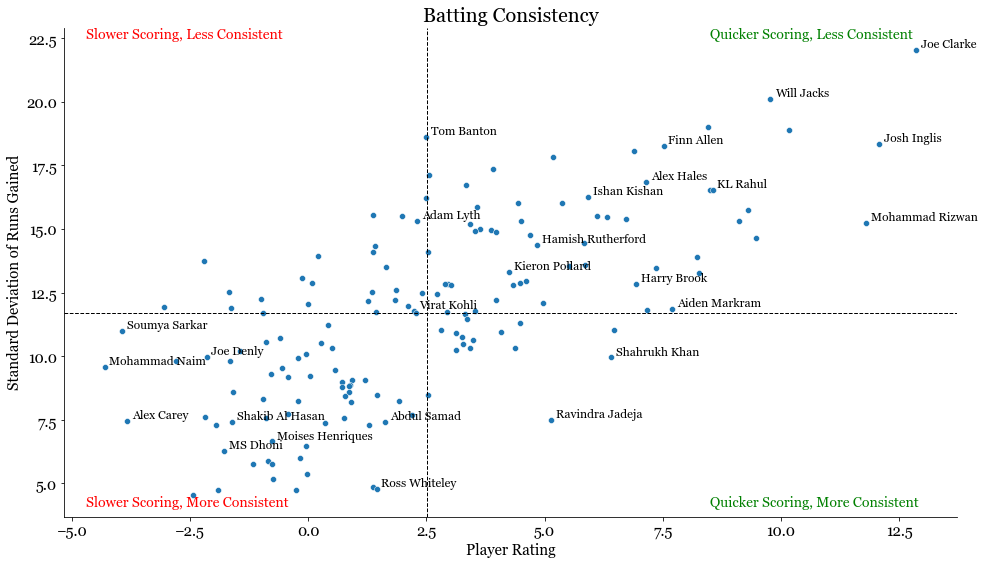

In [52]:
# Consistency Plot 
fig = plt.figure(figsize=(16,9))

ax = sns.scatterplot(data=bat_std, x="player_rating", y="std_dev")

names_to_plot = ['Joe Clarke', 'Kieron Pollard', 'Finn Allen', 'Josh Inglis', 'KL Rahul',
                'Ishan Kishan', 'Alex Hales', 'Aiden Markram', 'Hamish Rutherford',
                'Adam Lyth', 'Shakib Al Hasan', 'Ross Whiteley', 'Abdul Samad',
                'Mohammad Naim', 'Joe Denly', 'Virat Kohli', 'Moises Henriques', 'Alex Carey', 'Will Jacks',
                'Mohammad Rizwan', 'Ravindra Jadeja', 'Shahrukh Khan', 'Harry Brook', 'Tom Banton',
                'Soumya Sarkar', 'MS Dhoni']

for i in range(len(bat_std)):
    if bat_std['batsman_striker_name'][i] in names_to_plot:
        ax.text(bat_std['player_rating'][i] + 0.1,
                y=bat_std['std_dev'][i] + 0.1,
                s=bat_std['batsman_striker_name'][i],
                alpha=1,
                fontsize = 12)

ax.axhline(y=bat_std['std_dev'].mean(), color='k', linestyle='--', linewidth=1)           
ax.axvline(x=bat_std['player_rating'].mean(), color='k',linestyle='--', linewidth=1) 

ax.text(x=8.5, y=22.5, s="Quicker Scoring, Less Consistent",fontsize=14, color='green')
ax.text(x=8.5, y=4.1, s="Quicker Scoring, More Consistent",fontsize=14, color='green')
ax.text(x=-4.7, y=4.1, s="Slower Scoring, More Consistent", fontsize=14, color='red')
ax.text(x=-4.7, y=22.5, s="Slower Scoring, Less Consistent", fontsize=14, color='red')   

ax.set_title("Batting Consistency", size=20)
ax.set_xlabel("Player Rating", size=15)
ax.set_ylabel("Standard Deviation of Runs Gained", size=15)

ax.tick_params(axis='both', which='major', labelsize=15)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

## Match-Ups

Match-ups are obviously a very common talking point in T20 cricket now, and we can use runs gained to see which match-ups have been particularly successful or unsuccessful in the past. In the list below, the standout one to me is Buttler v Bhuvi - in this test set, it's rare that a bowler dominant match-up would have 40 balls, since a key reason that the bowler would be dominant is because they've dismissed the batter, and therefore no more balls are bowled for that match-up. In the recent T20I series in England this continued, where Bhuvi got Buttler out 2/3 times. These historical match-up ratings could be used to feed into predicted match-ups to inform strategy before a match.

In [53]:
# Calculating match ups
matchups = results.groupby(
    ['batsman_striker_name', 'bowler_name'], as_index = False
).agg(
    {'batter_balls_faced':'count', 'runs_gained':'mean'}
)

In [54]:
matchups[matchups['batter_balls_faced'] >= 40].sort_values('runs_gained')

,batsman_striker_name,bowler_name,batter_balls_faced,runs_gained
16497,Jos Buttler,Bhuvneshwar Kumar,40,-0.605465
10549,Faf du Plessis,Sunil Narine,40,-0.328352
17185,KL Rahul,Ish Sodhi,46,-0.167408
3464,Ashmit Shreshta,Solomon Williams,43,-0.092890
17386,Kane Williamson,Axar Patel,40,-0.053160
22286,Mitchell Marsh,Shakib Al Hasan,40,-0.002973
17379,Kane Williamson,Adam Zampa,42,0.044987
28491,Rohit Sharma,Mitchell Santner,58,0.206026
9329,Devon Conway,Cole McConchie,42,0.221480
2162,Amoluk Singh,Zappy Bimenyimana,49,0.222677


# Developments

## Add Batter/Bowler Adjustment

Currently, this rating system model doesn't account for the quality of the batter or bowler. Obviously this would be an important consideration in assessing players since it is clearly more impressive for batters to score quickly against the best bowlers, and equally it is more impressive to conceded fewer runs against the best batters. 

To do this would involve separate models - for the batting model, I would include a variable like *Bowler's Career Economy*, which would give an indication of how the average batter would fare against that bowler in that game scenario, and then the actual batter would be assessed against that average batter. And the same the other way round for the bowling model. They would have to be separate because if you included for example a *Bowler's Career Economy* variable, then the model would be biased against the better bowlers, since the expected runs baseline would be lower for them than other bowlers. 

While this would make the player ratings more accurate, it would mean that the model is no longer zero-sum (where the batter's runs gained is equal to the bowler's runs lost). A zero-sum model can be useful for certain reasons, such as the match-up analysis above. 

## Add Venues

Similarly, the model doesn't currently account for venue dynamics. This has a big impact on how many runs we would expect from a given ball, so would be a valuable addition to the model. Some venues are just higher scoring than others, so an innings of 30(25) might be a good innings at one ground but a bad innings at another. 

But it can also be more granular than that - for example, there are venues which favour spin bowling, whether for the surface (e.g. Chennai) or the ground dimensions (e.g. Old Trafford), so scoring runs against spinners at those venues would be more impressive than scoring runs against seamers. Another example could be venues (e.g. subcontinental grounds generally) where dew plays an important factor, so run scoring is generally easier in the 2nd innings. Again, incorporating this into the model should make the player ratings more accurate.

## Add Competitions

Another key consideration is the relative strength of different competitions. Without this, the ratings can be misleading. In the top 10 batters, we have 4 players who play predominantly in the T20 Blast in England (Clarke, Bell-Drummond, Jacks and Crawley). The standard of bowling in particular is weaker in the Blast than in competitions such as the IPL, PSL etc., so it is easier for those players to gain runs than players who have played predominantly in the IPL or PSL. 

While this would to some extent be mitigated by adding the batter/bowler adjustment mentioned above, whatever indicator of opponent quality you used (e.g. career economy/strike rate), this too would be biased by whatever the strength of competitions that the opponent played in. 

To factor this in, I would see how players' performance translates across different competitions. For example, if Will Jacks gained on average 8 runs in the Blast, 4 runs in the BPL and -2 runs in the PSL, we could infer that the bowling strength in the BPL is stronger than the Blast, and stronger in the PSL than the BPL. Doing this over all the players who've played in the different competitions would give us a conversion rate between them all. This would mean we can more accurately compare players across the world.